# How to run SPAMM

The only required inputs to run `SPAMM` are:
1. A source AGN spectrum
2. A list of which components to fit

However, there are numerous optional input arguments available. Since there are dozens of optional parameters, they have been separated out into a configuration file, `parameters.yaml`. An example default file is provided in `spamm/utils/parameters.yaml`. Users will want to modify this file or create their own with the same format. Any parameters file can be specified at runtime- if one is not found, the default will be used.

## Getting Started

`SPAMM` can accept the required input spectrum in three different forms: 
1. `spamm.Spectrum` instance
2. `specutils.Spectrum1D` instance
3. tuple containing the wavelength and flux and optionally, the error on the flux

All three methods will be shown below.

The list of acceptable components to fit are listed below (they are case insensitive):
- `PL` (Nuclear Continuum)
- `FE` (Iron Forect)
- `HOST` (Host Galaxy)
- `BC` (Balmer Continuum)
- `BPC` (Balmer Pseudo Continuum)
- `CALZETTI_EXT` (Calzetti extinction curves)
- `SMC_EXT` (Small Magellanic Cloud extinction curves)
- `LMC_EXT` (Large Magellanic Cloud extinction curves)
- `MW_EXT` (Milky Way extinction curves)
- `AGN_EXT` (AGN extinction curves)

For all of our examples, we'll just use the Nuclear Continuum/Power Law component so that computation time is fast.

### From a `spamm.Spectrum` instance

In [1]:
import matplotlib
#%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import astropy.units as u
from astropy.modeling.powerlaws import PowerLaw1D

from spamm.run_spamm import spamm
from spamm.Spectrum import Spectrum

In [2]:
# Define the unit-less wavelength and flux
wavelength = np.arange(1000, 2000)

# Just generate a simple sample power law for a spectrum
pl = PowerLaw1D(amplitude=1.5e-17, x_0=1500, alpha=2.0)
flux = pl(wavelength)

# Make the error 5% of the flux array 
flux_error = flux * 0.05

# If no wavelength and flux units are provided upon instantiation, 
# they will be retrieved from the parameters.yaml file.
inspectrum = Spectrum(spectral_axis=wavelength, flux=flux, flux_error=flux_error,
                      spectral_axis_unit=u.AA, flux_unit=u.Unit('erg cm-2 s-1 AA-1'))

Text(0.5, 1.0, 'Test input spectrum')

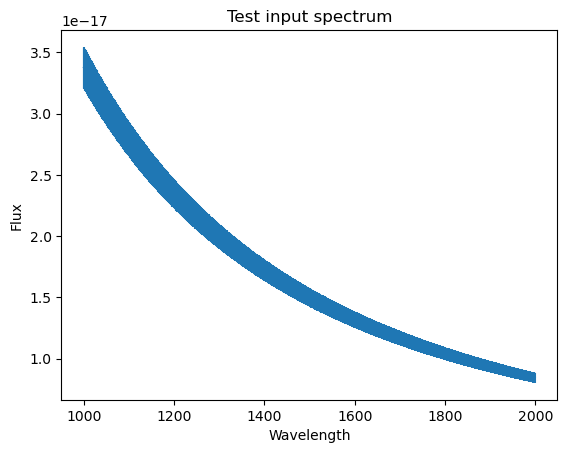

In [3]:
plt.errorbar(wavelength, flux, flux_error)
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.title("Test input spectrum")

In [4]:
# Let's fit only the Nuclear Continuum component.
#spamm_out = spamm(complist=["PL"], inspectrum=inspectrum)

### From a `specutils.Spectrum1D` instance
The most important thing to note when starting from a `specutils.Spectrum1D` object is that `Spectrum1D` requires the wavelength and flux arrays to be `astropy.unit.Quantity` objects. While an input uncertainty is an optional parameter when instantiating `Spectrum1D`, it is required when instantiating a `spamm.Spectrum` object and therefore should be passed into `Spectrum1D` before using `spamm`. 
`Spectrum1D` requires the uncertainty to be an `astropy.nddata.NDUncertainty` object.

In [5]:
from specutils import Spectrum1D
from astropy.nddata import StdDevUncertainty

In [6]:
# specutils.Spectrum1D objects must be instantiated with units.
wavelength_q = wavelength * u.AA
flux_q = flux * u.Unit('erg cm-2 s-1 AA-1')
flux_error_q = flux_q * 0.05
# Explicit array and unit arguments are shown below to illustrate how they are passed in.
uncertainty = StdDevUncertainty(flux_error_q.value, unit=flux_error_q.unit)

In [7]:
inspectrum = Spectrum1D(spectral_axis=wavelength_q, flux=flux_q, uncertainty=uncertainty)
#spamm_out = spamm(complist=["PL"], inspectrum=inspectrum)

### From a tuple

In [8]:
# Create a tuple with the wavelength, flux, and flux error arrays. 
intup = (wavelength, flux, flux_error)

In [9]:
# Note that when the input spectrum is defined as a tuple, 
# the wavelength and flux units will be retrieved from the parameters file.
#spamm_out = spamm(complist=["PL"], inspectrum=intup)

### Specifying an input parameters file
An input `parameters.yaml` can be specified on runtime using the `par_file` argument. If one is not specified, the default file will be used.

In [10]:
# Uncomment this if you want to try it.
#spamm_out = spamm(complist=["PL"], inspectrum=inspectrum, par_file="parameters.yaml")

### Specifying output file names and locations
There are several output files (see below); it is possible to change their default names and locations. For the output pickle file:

In [11]:
# You can choose to include the extension name or not, both options below are acceptable.
#spamm_out = spamm(complist=["PL"], inspectrum=inspectrum, picklefile="mypicklefile")
#spamm_out = spamm(complist=["PL"], inspectrum=inspectrum, picklefile="mypicklefile.pickle.gz")

The output directory need not exist, it will be created if necessary. To change the directory where the pickle file and plots will be written:

In [12]:
#spamm_out = spamm(complist=["PL"], inspectrum=inspectrum, outdir="/path/to/my/output",picklefile="mypicklefile")

### MCMC input arguments
You can also specify the number of walkers and iterations for `emcee` ([documentation here](http://dfm.io/emcee/current/)). 

In [13]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [16]:
spamm_out = spamm(complist=['PL'], inspectrum=inspectrum, n_walkers=30, n_iterations=2000,
                  par_file="parameters.yaml",
                 outdir="/Users/oddam/Library/CloudStorage/Dropbox/Universitet/phd_project/SPAMM/examples/TEST", picklefile="TEST",
                 comp_params={"broken_pl": False})
 #

100%|████████████████████████████████████████| 2000/2000 [00:10<00:00, 191.50it/s]


Mean acceptance fraction: 0.704
Saved pickle file /Users/oddam/Library/CloudStorage/Dropbox/Universitet/phd_project/SPAMM/examples/TEST/TEST.pickle.gz
Plotting the sample projections.
	Saved TEST_triangle.png
Plotting the MCMC chains.
	Saved TEST_chain.png
Plotting the model posterior PDFs.
	Saved TEST_posterior.png
Saved /Users/oddam/Library/CloudStorage/Dropbox/Universitet/phd_project/SPAMM/examples/TEST/TEST_posterior.pdf
executed in 0:00:12.911750


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Running from the command line
`SPAMM` is designed to be run programatically. Sorry.

## Interpreting the results

### Output files
#### Pickle file
For each successful `SPAMM` run, an output pickle file will be written. By default this filename will reflect the datetime at code finish with the following format:<br/>
`model_YYYYMMDD_mmss.pickle.gz`<br/>
e.g. `model_20191231_1059.pickle.gz`<br/>

Pickle files are by default written to a directory with the same runtime string, e.g.:<br/>
`20191231_1059/model_20191231_1059.pickle.gz`

As mentioned above, though, both the output directory name and pickle filename can be specified at runtime. 

The pickle file contains all information regarding the results from `emcee`. To read this pickle file in, use the `Samples` class:

In [ ]:
from spamm.Samples import Samples

In [ ]:
S = Samples("20231113_2209/model_20231113_2209.pickle.gz")

# Some useful attributes of a Samples object
print("The pickle file name is:\n\t{}".format(S.pname))
print("The component parameter names are:\n\t{}".format(S.model_parameter_names))
print("The max values on the PDF for these paramters are:\n\t{}".format(S.maxs))

In [ ]:
# You can also access the MCMC samples from emcee
print(np.shape(S.samples))
S.samples

### Plots

At the end of a successfull `SPAMM` run you will see where the output plots have been written. Let's inspect some of these plots.

#### Triangle plot
The triangle plot shows the projections of a set of samples in a multi-dimensional space. This is useful for visualizing the MCMC chain. 

In [ ]:
from spamm.analysis import corner, plot_chains, plot_posteriors_pdf
from spamm.Samples import Samples

S = Samples("20231113_2209/model_20231113_2209.pickle.gz")

In [ ]:
corner(S.samples, labels=S.model_parameter_names)

#### Chain plot

This shows the accepted value of each parameter as a function of chain iteration.

In [ ]:
plot_chains(S.samples, labels=S.model_parameter_names)

#### Posterior plot

Each page in this output `.pdf` file shows a histogram for each component parameter. Overplotted are lines signifying the mean, median, mode, and maximum of the distribution. The 1$\sigma$ limits are also shown. 

In [ ]:
#plot_posteriors_pdf(S)

In [ ]:
def power_law(x, norm_pl, slope):
    return norm_pl*(x/1500)**(-slope)

In [ ]:
mean_vals = np.mean(S.samples, axis=0)

plt.plot(wavelength, flux, lw=4)
plt.plot(wavelength, power_law(wavelength, mean_vals[0], mean_vals[1]))

In [ ]:
# Define the unit-less wavelength and flux
wavelength = np.arange(1000, 2000)

# Use a more complicated spectrum this time
pl = PowerLaw1D(amplitude=1.5e-17, x_0=1500, alpha=2.0)
flux = pl(wavelength)

# Make the error 5% of the flux array 
flux_error = flux * 0.05

# If no wavelength and flux units are provided upon instantiation, 
# they will be retrieved from the parameters.yaml file.
inspectrum = Spectrum(spectral_axis=wavelength, flux=flux, flux_error=flux_error,
                      spectral_axis_unit=u.AA, flux_unit=u.Unit('erg cm-2 s-1 AA-1'))

#spamm_out = spamm(complist=['PL'], inspectrum=inspectrum, n_walkers=30, n_iterations=500)